In [16]:
import cv2
import numpy as np
import PIL
import os
import utils
import matplotlib.pyplot as plt 

In [17]:
file1 = 'E:\\Code\\lane_detect\\test_images\\straight_lines1.jpg'
test_img1 = cv2.imread(file1)



In [18]:
def get_obj_img_points(images, grid=(9,6)):
    object_points = []
    img_points = []
    for img in images:
        object_point = np.zeros( (grid[0]*grid[1],3),np.float32 )
        object_point[:,:2]= np.mgrid[0:grid[0],0:grid[1]].T.reshape(-1,2)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, grid, None)
        if ret:
            object_points.append(object_point)
            img_points.append(corners)

    return object_points, img_points

In [19]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist,rvecs, tves = cv2.calibrateCamera(objpoints,imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


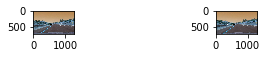

In [20]:
cal_imgs = utils.get_images_by_dir('camera_cal')

#计算object_points,img_points
object_points,img_points = get_obj_img_points(cal_imgs,grid=(9,6))
#获取测试图片
test_imgs = utils.get_images_by_dir('test_images')

#校正测试图片
undistorted = []
i = 0
j = 1
for img in test_imgs:
    img = cal_undistort(img,object_points,img_points)
    undistorted.append(img)
    
plt.figure()
plt.subplot(8,2,1)
plt.imshow(test_imgs[0])
plt.subplot(8,2,2)
plt.imshow(undistorted[0]) 

plt.show()

In [21]:
def get_images_by_dir(dirname):
    img_names = os.listdir(dirname)
    img_paths = [dirname+'/'+img_name for img_name in img_names]
    imgs = [cv2.imread(path) for path in img_paths]
    return imgs

In [22]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #装换为灰度图片
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #使用cv2.Sobel()计算计算x方向或y方向的导数
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    #阈值过滤
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

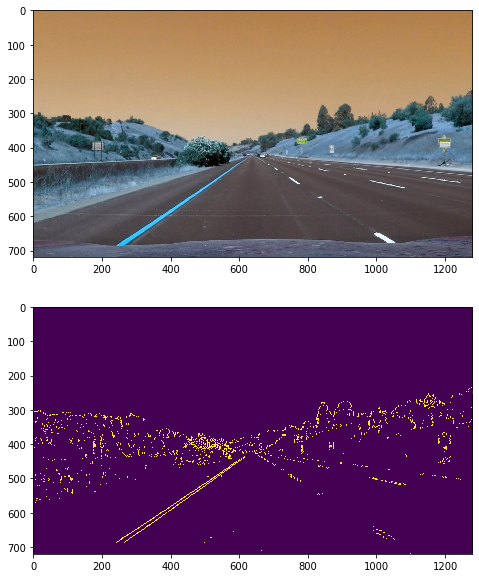

In [23]:
binary_output = abs_sobel_thresh(test_img1, orient='x',thresh_min=35, thresh_max=100)
# cv2.imshow("binary",binary_output)
# cv2.waitKey(0)
# plt.imshow(binary_output)
# plt.show()
plt.figure(figsize=(10,10))
plt.subplot(2,1,1),plt.imshow(test_img1)
plt.subplot(2,1,2), plt.imshow(binary_output)

plt.show()


In [24]:
cv2.imshow("image",test_img1)
cv2.waitKey(0)


gray = cv2.cvtColor(test_img1, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray",gray)
cv2.waitKey(0)



-1

In [25]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

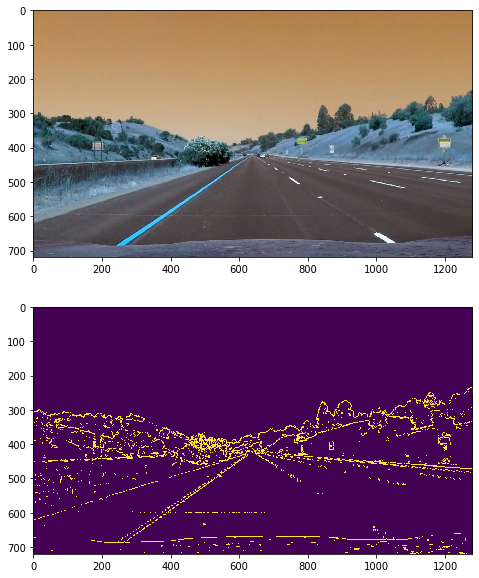

In [26]:
binary_output = mag_thresh(test_img1,sobel_kernel=3, mag_thresh=(35, 100))
# cv2.imshow("binary",binary_output)
# cv2.waitKey(0)
# plt.imshow(binary_output)
# plt.show()
plt.figure(figsize=(10,10))
plt.subplot(2,1,1),plt.imshow(test_img1)
plt.subplot(2,1,2), plt.imshow(binary_output)

plt.show()


In [27]:
def hls_select(img,channel='s',thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel=='h':
        channel = hls[:,:,0]
    elif channel=='l':
        channel=hls[:,:,1]
    else:
        channel=hls[:,:,2]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

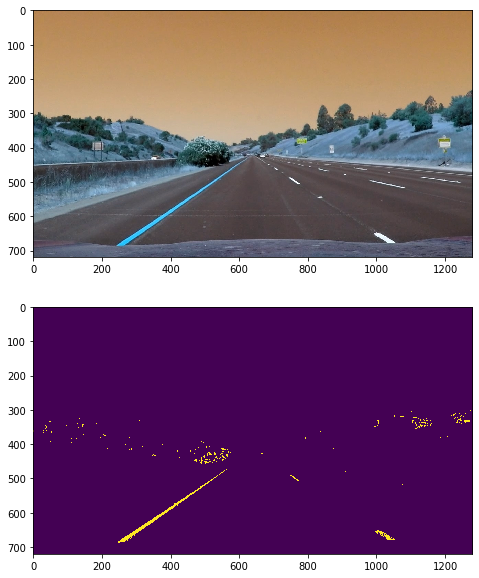

In [28]:
binary_output = hls_select(test_img1,channel='s',thresh=(180, 255))
plt.figure(figsize=(10,10))
plt.subplot(2,1,1),plt.imshow(test_img1)
plt.subplot(2,1,2), plt.imshow(binary_output)

plt.show()

In [29]:
def thresholding(img):
    x_thresh = utils.abs_sobel_thresh(img, orient='x', thresh_min=10 ,thresh_max=230)
    mag_thresh = utils.mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150))
    dir_thresh = utils.dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_thresh = utils.hls_select(img, thresh=(180, 255))
    lab_thresh = utils.lab_select(img, thresh=(155, 200))
    luv_thresh = utils.luv_select(img, thresh=(225, 255))
    #Thresholding combination
    threshholded = np.zeros_like(x_thresh)
    threshholded[((x_thresh == 1) & (mag_thresh == 1)) | ((dir_thresh == 1) & (hls_thresh == 1)) | (lab_thresh == 1) | (luv_thresh == 1)] = 1

    return threshholded

In [30]:
binary_output = thresholding(test_img1)
plt.figure(figsize=(20,20))
plt.subplot(2,1,1),plt.imshow(test_img1)
plt.subplot(2,1,2), plt.imshow(binary_output)

plt.show()

AttributeError: module 'utils' has no attribute 'abs_sobel_thresh'